# Example usage

In [2]:
import random

import shap
import numpy as np
import pandas as pd
import seaborn as sns
from dowhy import gcm
import networkx as nx
from PyALE import ale
from scipy import stats
from sklearn import base
from matplotlib import rc
import matplotlib.pyplot as plt
from cdt.data import load_dataset
from scmtools.utils import get_dot_graph
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import PartialDependenceDisplay
from scmtools.model import build_ground_truth_causal_model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from cdp import CausalDependencePlotter, UncertainCausalDependencePlotter

# set up color palette and plot styling
rc('font', **{'family': 'sans-serif', 'sans-serif': ['DejaVu Sans'], 'size': 12})
plt.style.use('tableau-colorblind10')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_pallette = [
    ('#66C2A5', '#AFDFD0'),
    ('#FB8D62', '#FDC9B4'),
    ('#8E9FCB', '#CBD2E7'),
    ('#E78AC3', '#F2C0DE'),
    ('#A5D853', '#DEF1C1'),
    ('#FFD92F' '#FFF1B3')
]
pale_red = colors[5]
pale_gray = colors[2]
colors[5] = color_pallette[4][0]
colors[2] = color_pallette[4][1]

## Building a ground truth causal model

Below we instantiate the following ground truth causal model.

\begin{align}
X &= U_X\\
M_1 &= \frac12 X^3 + U_{M_1}\\
M_2 &= \frac14 X^3 + U_{M_2}\\
Y &= M_1^2 + M_2^2 - \frac12 X^2 + U_Y\\
U_X, U_{M_1}, U_{M_2}, U_Y &\sim \mathcal{N}(0, 1)
\end{align}

In [3]:
true_outcome_function = lambda x: x[:, 0]**2 + x[:, 1]**2 - 0.5 * x[:, 2]**2
node_function_dict = {
    'X': (None, gcm.ScipyDistribution(stats.norm, loc=0, scale=1)),
    'M1': (lambda x: 0.5 * x**3, gcm.ScipyDistribution(stats.norm, loc=0, scale=1)),
    'M2': (lambda x: 0.25 * x**3, gcm.ScipyDistribution(stats.norm, loc=0, scale=1)),
    'Y': (true_outcome_function, gcm.ScipyDistribution(stats.norm, loc=0, scale=1))
}
causal_graph = nx.DiGraph([('X', 'M1'), ('X', 'M2'), ('X', 'Y'), ('M1', 'Y'), ('M2', 'Y')])
causal_model = build_ground_truth_causal_model(causal_graph=causal_graph, node_function_dict=node_function_dict)

Next we use our custom SCM to generate a dataset.

In [4]:
np.random.seed(123)
data_df = gcm.draw_samples(causal_model=causal_model, num_samples=1000)

# Explaining a black-box model

We can use our generated dataset as training data for a black-box prediction model that predicts $Y$ as a function of $X$ and $M$. For our first black-box model, we'll use a linear model. Note that the `CausalDependencePlotter` expects a black-box model of type `sklearn.base.BaseEstimator`.

In [5]:
black_box_X_train = data_df[['X', 'M1', 'M2']]
black_box_y_train = data_df['Y']

black_box_model = LinearRegression()
black_box_model.fit(black_box_X_train, black_box_y_train);

We instantiate our `CausalDependencePlotter` with the trained black-box model, the fit causal model, and an explanatory dataset. Note that the explanatory dataset doesn't have to match the training data nor involve outcome $Y$, but it must contain all columns in black_box_X_train. In general, the causal model needs to describe the DGP for at minimum the features in the explanatory dataset, but it's fine to also involve other variables (like the outcome in this case).

In [6]:
explanatory_X_data = data_df[['M1', 'M2', 'X']].sample(50, random_state=123)

plotter = CausalDependencePlotter(
    black_box_model=black_box_model,
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='Y',
    prefit_black_box=True
)

Next we use the methods `plot_total_effect()`, `plot_direct_effect()`, and `plot_indirect_effect()` to generate the TDP, NDDP, and NIDP for interventions on feature $X$. 

Plotting indirect effect: 100%|██████████| 50/50 [00:00<00:00, 95.73it/s]


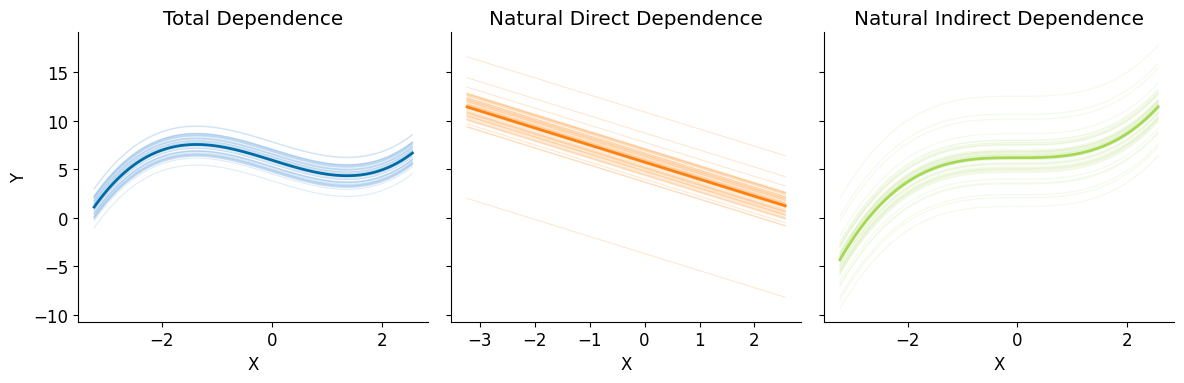

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharey=True)
axes = axes.ravel()
plotter.average_curve_color = colors[0]
plotter.individual_curve_color = colors[7]
plotter.plot_total_effect(treatment_var='X', axis=axes[0])
plotter.average_curve_color = colors[1]
plotter.individual_curve_color = colors[8]
plotter.plot_direct_effect(treatment_var='X', axis=axes[1])
plotter.average_curve_color = colors[5]
plotter.individual_curve_color = colors[2]
plotter.plot_indirect_effect(treatment_var='X', axis=axes[2])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

The TDP captures a cubic effect overall, decomposed into a linear effect shown in the NDDP and a cubic effect shown in the NIDP. To see the effect of $X$ on $\hat{Y}$ while controlling the influence of the two mediators $M_1, M_2$, we can use the `plot_controlled_effect()` function to generate the PCDP. Notice that we need to control both mediators in order to isolate the effect.

Sampling PCE counterfactuals: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


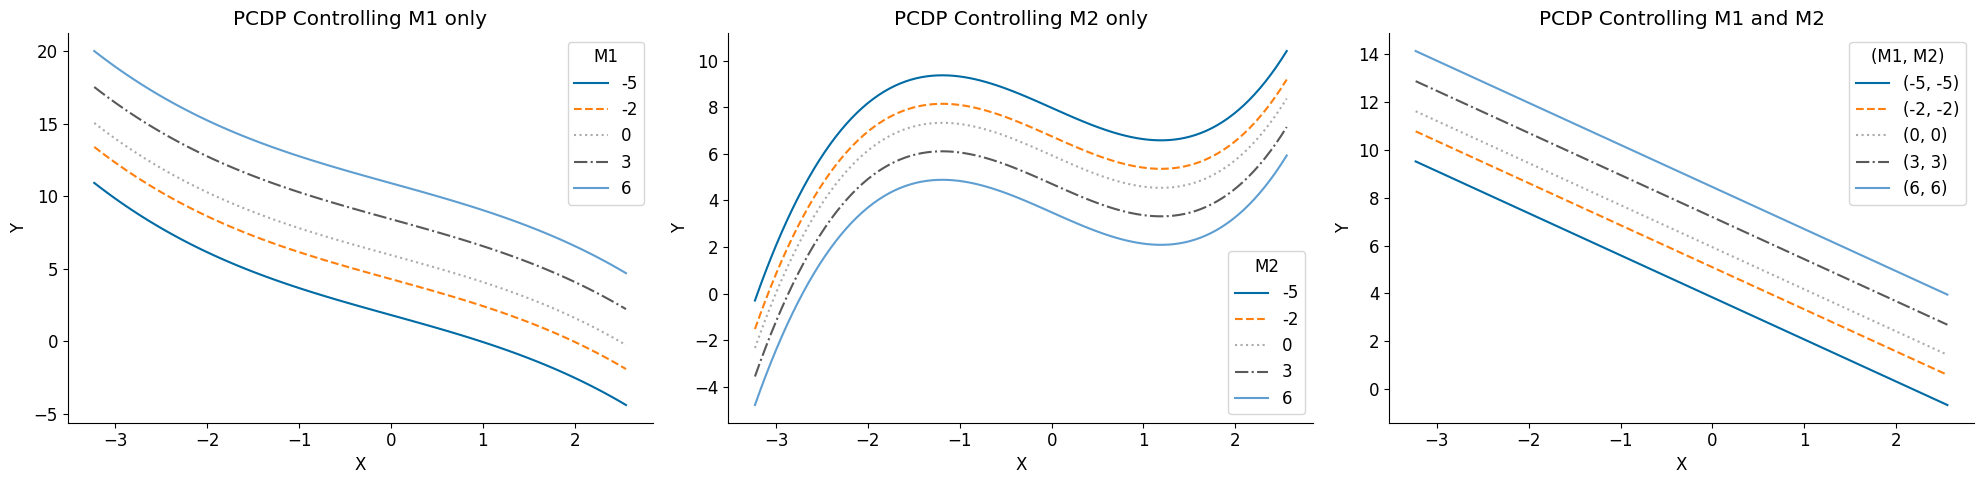

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
axes = axes.ravel()
plotter.plot_controlled_effect(treatment_var='X', control_vars=('M1',), control_tuples=[(-5,), (-2,), (0,), (3,), (6,)], combine_plots=True, axis=axes[0])
axes[0].set_title('PCDP Controlling M1 only')
plotter.plot_controlled_effect(treatment_var='X', control_vars=('M2',), control_tuples=[(-5,), (-2,), (0,), (3,), (6,)], combine_plots=True, axis=axes[1])
axes[1].set_title('PCDP Controlling M2 only')
plotter.plot_controlled_effect(treatment_var='X', control_vars=('M1', 'M2'), control_tuples=[(-5, -5), (-2, -2), (0, 0), (3, 3), (6, 6)], combine_plots=True, axis=axes[2])
axes[2].set_title('PCDP Controlling M1 and M2')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

Notice that these effects are on the output of the black-box model $\hat{Y}$, and will thus generally not match effects on $Y$ in the DGP (unless the black-box model reflects the true model for $Y$).

# Plotting the TDP, PCDP, NDDP, NIDP for the true model

In order to see what the TDP, PCDP, NDDP, and NIDP would look like if we had a perfect model of $Y$, we can define an `sklearn.base.BaseEstimator` that captures the true model for $Y$ and use it as our black-box model.

Sampling PCE counterfactuals: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


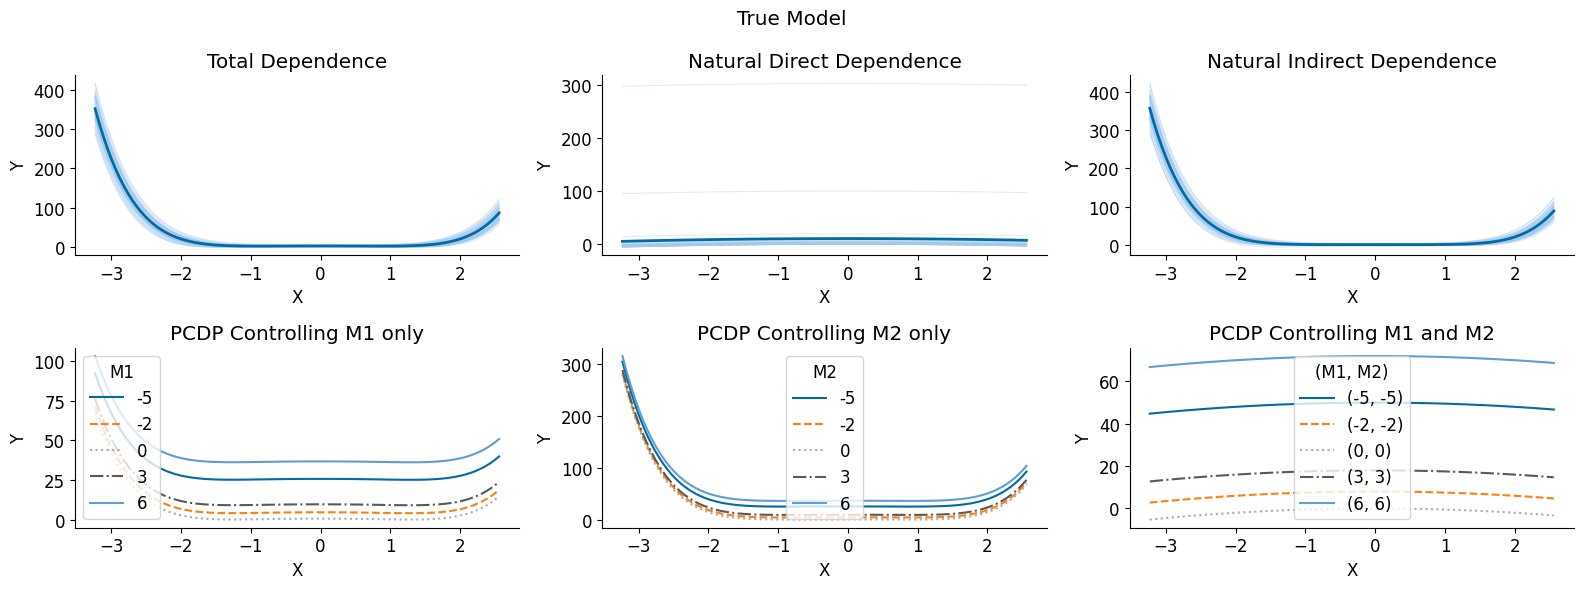

In [ ]:
class CorrectModel(base.BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X_df):
        X = X_df[['M1', 'M2', 'X']].values
        return true_outcome_function(X)

plotter_truth = CausalDependencePlotter(
    black_box_X_train=black_box_X_train, 
    black_box_y_train=black_box_y_train,
    black_box_model=CorrectModel(),
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='Y',
    average_curve_color = colors[0],
    individual_curve_color = colors[7]
)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 6))
axes = axes.ravel()
plotter_truth.plot_total_effect(treatment_var='X', axis=axes[0])
plotter_truth.plot_direct_effect(treatment_var='X', axis=axes[1])
plotter_truth.plot_indirect_effect(treatment_var='X', axis=axes[2])
plotter_truth.plot_controlled_effect(treatment_var='X', control_vars=('M1',), control_tuples=[(-5,), (-2,), (0,), (3,), (6,)], combine_plots=True, axis=axes[3])
axes[3].set_title('PCDP Controlling M1 only')
plotter_truth.plot_controlled_effect(treatment_var='X', control_vars=('M2',), control_tuples=[(-5,), (-2,), (0,), (3,), (6,)], combine_plots=True, axis=axes[4])
axes[4].set_title('PCDP Controlling M2 only')
plotter_truth.plot_controlled_effect(treatment_var='X', control_vars=('M1', 'M2'), control_tuples=[(-5, -5), (-2, -2), (0, 0), (3, 3), (6, 6)], combine_plots=True, axis=axes[5])
axes[5].set_title('PCDP Controlling M1 and M2')
plt.suptitle('True Model')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

# Single mediator example with 'correct' vs 'incorrect' black-box

We can plot side-by-side CDPs for two black box models -- one that captures the true DGP vs. one that doesn't, for the following DGP: $X \sim \mathcal{N}(0, 1); M = \frac{1}{2} X^3 + \mathcal{N}(0,1); Y = M^2 - \frac{1}{2}X^2 + \mathcal{N}(0,1)$.

Plotting indirect effect: 100%|██████████| 1000/1000 [00:21<00:00, 47.28it/s]


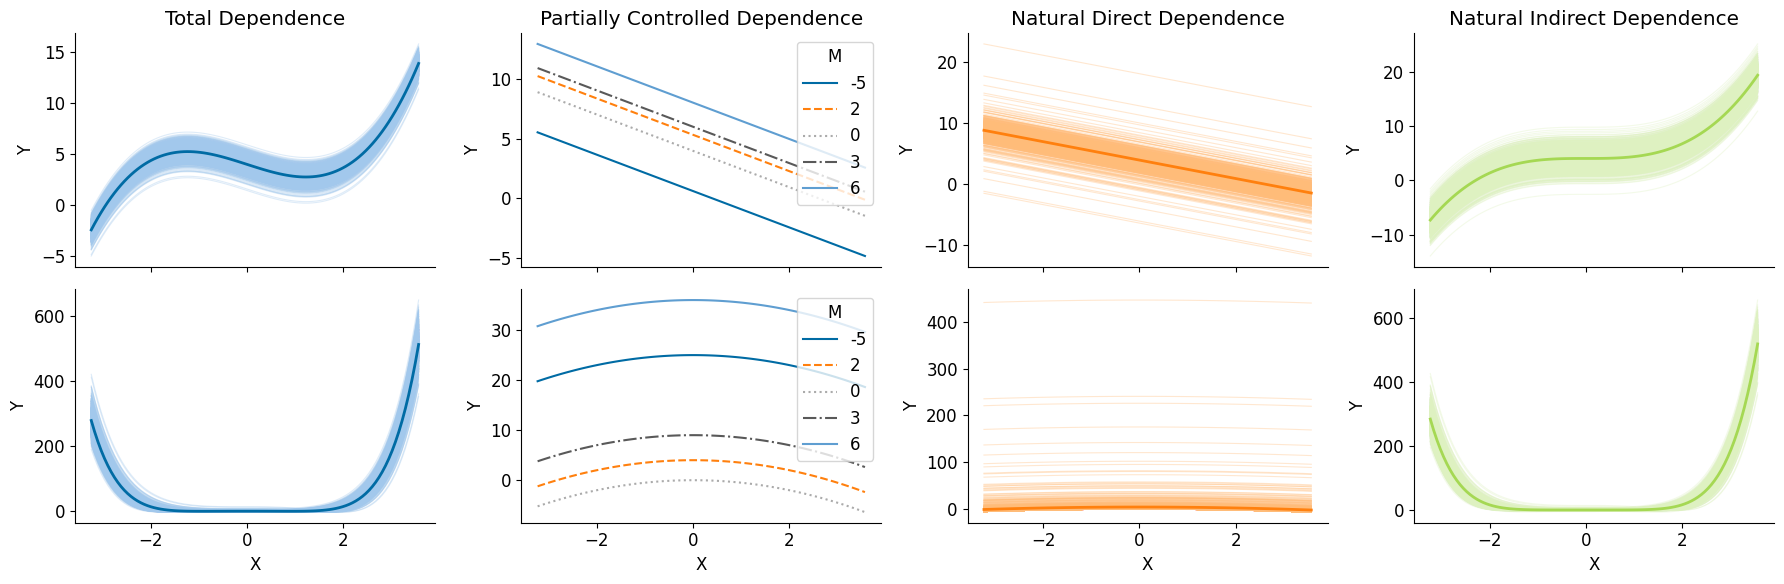

In [ ]:
np.random.seed(123)

true_outcome_function = lambda x: x[:, 0]**2 - 0.5 * x[:, 1]**2

class CorrectModel(base.BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X_df):
        X = X_df[['M', 'X']].values
        return true_outcome_function(X)

node_function_dict = {
    # node: (prediction_function, noise_model)
    'X': (None, gcm.ScipyDistribution(stats.norm, loc=0, scale=1)),
    'M': (lambda x: 0.5 * x**3, gcm.ScipyDistribution(stats.norm, loc=0, scale=1)),
    'Y': (true_outcome_function, gcm.ScipyDistribution(stats.norm, loc=0, scale=1))
}
causal_graph = nx.DiGraph([('X', 'M'), ('M', 'Y'), ('X', 'Y')])
causal_model = build_ground_truth_causal_model(causal_graph=causal_graph, node_function_dict=node_function_dict)

data_df = gcm.draw_samples(causal_model=causal_model, num_samples=1000)

black_box_X_train = data_df[['X', 'M']]
black_box_y_train = data_df['Y']

explanatory_X_data = data_df[['X', 'M']]

plotter_linmod = CausalDependencePlotter(
    black_box_X_train=black_box_X_train, 
    black_box_y_train=black_box_y_train,
    black_box_model=LinearRegression(),
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='Y',
    average_curve_color=colors[0],
    individual_curve_color=colors[7]
)

plotter_truth = CausalDependencePlotter(
    black_box_X_train=black_box_X_train, 
    black_box_y_train=black_box_y_train,
    black_box_model=CorrectModel(),
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='Y',
    average_curve_color=colors[0],
    individual_curve_color=colors[7]
)

treatment_name = 'X'
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 6), sharey=False, sharex=True)
axes = axes.ravel()
plotter_linmod.plot_total_effect(treatment_var=treatment_name, axis=axes[0])
plotter_linmod.plot_controlled_effect(
    treatment_var=treatment_name, 
    control_vars=('M',), 
    control_tuples=[(-5,), (2,), (0,), (3,), (6,)], 
    combine_plots=True, 
    axis=axes[1]
)
plotter_linmod.average_curve_color = colors[1]
plotter_linmod.individual_curve_color = colors[8]
plotter_linmod.plot_direct_effect(treatment_var=treatment_name, axis=axes[2])
plotter_linmod.average_curve_color = colors[5]
plotter_linmod.individual_curve_color = colors[2]
plotter_linmod.plot_indirect_effect(treatment_var=treatment_name, axis=axes[3])
plotter_truth.plot_total_effect(treatment_var=treatment_name, axis=axes[4])
axes[4].set_title('')
plotter_truth.plot_controlled_effect(
    treatment_var=treatment_name, 
    control_vars=('M',), 
    control_tuples=[(-5,), (2,), (0,), (3,), (6,)], 
    combine_plots=True, 
    axis=axes[5]
)
axes[5].set_title('')
plotter_truth.average_curve_color = colors[1]
plotter_truth.individual_curve_color = colors[8]
plotter_truth.plot_direct_effect(treatment_var=treatment_name, axis=axes[6])
axes[6].set_title('')
plotter_truth.average_curve_color = colors[5]
plotter_truth.individual_curve_color = colors[2]
plotter_truth.plot_indirect_effect(treatment_var=treatment_name, axis=axes[7])
axes[7].set_title('')
axes[1].legend(title='M', loc='upper right')
axes[5].legend(title='M', loc='upper right')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

# Assuming an incorrect ECM

CDPs still have limitations. For example, if we assume an ECM that is incorrect in an important way, a CDP can be qualitatively wrong. Let's revisit the DGP from the beginning of the notebook:

\begin{align}
X &= U_X\\
M_1 &= \frac12 X^3 + U_{M_1}\\
M_2 &= \frac14 X^3 + U_{M_2}\\
Y &= M_1^2 + M_2^2 - \frac12 X^2 + U_Y\\
U_X, U_{M_1}, U_{M_2}, U_Y &\sim \mathcal{N}(0, 1)
\end{align}

In one case, we will assume the correct SCM. In the next case, we will assume an incorrect graphical structure ($M_1 \rightarrow X \rightarrow M_2$) and fit the incorrect ECM to the data using additive noise models. This simulates what would happen if we had the connections between variables correct but assumed the incorrect direction of causality between $M_1$ and $X$.

We will repeat the plot from above, now with two mediators instead of one, and adding a third row to the plot, where each row demonstrates the following:
- Row 1: 'correct' black-box model with correct ECM
- Row 2: 'incorrect' black-box model with correct ECM
- Row 3: 'correct' black-box model with incorrect ECM



Fitting causal mechanism of node M2: 100%|██████████| 3/3 [00:00<00:00, 236.37it/s]


Sampling TE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting total effect:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling PCE counterfactuals:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling NDE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting direct effect:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling NIE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting indirect effect:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling TE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting total effect:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling PCE counterfactuals:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling NDE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting direct effect:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling NIE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting indirect effect:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling TE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting total effect:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling PCE counterfactuals:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling NDE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting direct effect:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling NIE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting indirect effect:   0%|          | 0/1000 [00:00<?, ?it/s]

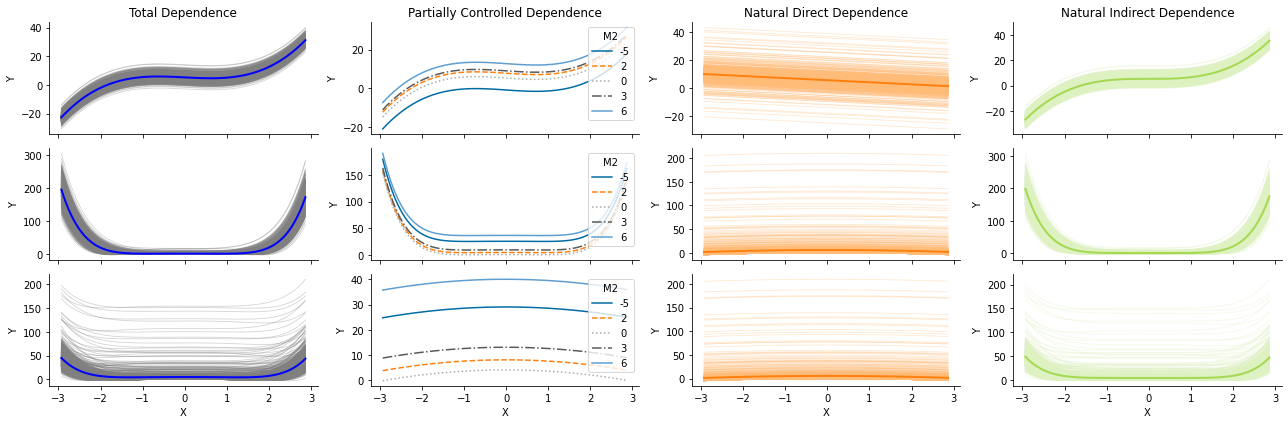

In [ ]:
np.random.seed(123)

# instantiate DGP
true_outcome_function = lambda x: x[:, 0]**2 + x[:, 1]**2 - 0.5 * x[:, 2]**2
node_function_dict = {
    'X': (None, gcm.ScipyDistribution(stats.norm, loc=0, scale=1)),
    'M1': (lambda x: 0.5 * x**3, gcm.ScipyDistribution(stats.norm, loc=0, scale=1)),
    'M2': (lambda x: 0.25 * x**3, gcm.ScipyDistribution(stats.norm, loc=0, scale=1)),
    'Y': (true_outcome_function, gcm.ScipyDistribution(stats.norm, loc=0, scale=1))
}
causal_graph = nx.DiGraph([('X', 'M1'), ('X', 'M2'), ('X', 'Y'), ('M1', 'Y'), ('M2', 'Y')])
causal_model = build_ground_truth_causal_model(causal_graph=causal_graph, node_function_dict=node_function_dict)

class CorrectModel(base.BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X_df):
        x = X_df[['M1', 'M2', 'X']].values
        return true_outcome_function(x)

# sample dataset
np.random.seed(456)
data_df = gcm.draw_samples(causal_model=causal_model, num_samples=1000)

# fit black-box model
black_box_X_train = data_df[['X', 'M1', 'M2']]
black_box_y_train = data_df['Y']
black_box_model = LinearRegression()
black_box_model.fit(black_box_X_train, black_box_y_train);

explanatory_X_data = data_df[['X', 'M1', 'M2']]

# instantiate an ECM that is incorrect and fit it to the data with auto-assigned additive noise mechanisms
wrong_causal_graph = nx.DiGraph([('M1', 'X'), ('X', 'M2')])
wrong_causal_model = gcm.InvertibleStructuralCausalModel(graph=wrong_causal_graph)
gcm.auto.assign_causal_mechanisms(causal_model=wrong_causal_model, based_on=data_df, quality=gcm.auto.AssignmentQuality.BETTER)
gcm.fit(causal_model=wrong_causal_model, data=data_df)


plotter_linmod = CausalDependencePlotter(
    black_box_model=black_box_model,
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='Y',
    prefit_black_box=True
)

plotter_truth = CausalDependencePlotter(
    black_box_X_train=black_box_X_train, 
    black_box_y_train=black_box_y_train,
    black_box_model=CorrectModel(),
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='Y',
    prefit_black_box=False
)

plotter_wrong_graph = CausalDependencePlotter(
    black_box_X_train=black_box_X_train, 
    black_box_y_train=black_box_y_train,
    black_box_model=CorrectModel(),
    fit_causal_model=wrong_causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='Y',
    prefit_black_box=False
)

treatment_name = 'X'
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 6), sharey=False, sharex=True)
axes = axes.ravel()
plotter_linmod.plot_total_effect(treatment_var=treatment_name, axis=axes[0])
plotter_linmod.plot_controlled_effect(
    treatment_var=treatment_name, 
    control_vars=('M2',), 
    control_tuples=[(-5,), (2,), (0,), (3,), (6,)], 
    combine_plots=True, 
    axis=axes[1]
)
plotter_linmod.average_curve_color = colors[1]
plotter_linmod.individual_curve_color = colors[8]
plotter_linmod.plot_direct_effect(treatment_var=treatment_name, axis=axes[2])
plotter_linmod.average_curve_color = colors[5]
plotter_linmod.individual_curve_color = colors[2]
plotter_linmod.plot_indirect_effect(treatment_var=treatment_name, axis=axes[3])

plotter_truth.plot_total_effect(treatment_var=treatment_name, axis=axes[4])
axes[4].set_title('')
plotter_truth.plot_controlled_effect(
    treatment_var=treatment_name, 
    control_vars=('M2',), 
    control_tuples=[(-5,), (2,), (0,), (3,), (6,)], 
    combine_plots=True, 
    axis=axes[5]
)
axes[5].set_title('')
plotter_truth.average_curve_color = colors[1]
plotter_truth.individual_curve_color = colors[8]
plotter_truth.plot_direct_effect(treatment_var=treatment_name, axis=axes[6])
axes[6].set_title('')
plotter_truth.average_curve_color = colors[5]
plotter_truth.individual_curve_color = colors[2]
plotter_truth.plot_indirect_effect(treatment_var=treatment_name, axis=axes[7])
axes[7].set_title('')

plotter_wrong_graph.plot_total_effect(treatment_var=treatment_name, axis=axes[8])
axes[8].set_title('')
plotter_wrong_graph.plot_controlled_effect(
    treatment_var=treatment_name, 
    control_vars=('M2',), 
    control_tuples=[(-5,), (2,), (0,), (3,), (6,)], 
    combine_plots=True, 
    axis=axes[9]
)
axes[9].set_title('')
plotter_wrong_graph.average_curve_color = colors[1]
plotter_wrong_graph.individual_curve_color = colors[8]
plotter_wrong_graph.plot_direct_effect(treatment_var=treatment_name, axis=axes[10])
axes[10].set_title('')
plotter_wrong_graph.average_curve_color = colors[5]
plotter_wrong_graph.individual_curve_color = colors[2]
plotter_wrong_graph.plot_indirect_effect(treatment_var=treatment_name, axis=axes[11])
axes[11].set_title('')


axes[1].legend(title='M2', loc='upper right')
axes[5].legend(title='M2', loc='upper right')
axes[9].legend(title='M2', loc='upper right')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

In [ ]:
explainer = shap.Explainer(black_box_model.predict, explanatory_X_data[black_box_model.feature_names_in_])
shap_values = explainer(explanatory_X_data[black_box_model.feature_names_in_])

features = black_box_model.feature_names_in_

CorrectModel().fit(black_box_X_train, black_box_y_train)
explainer2 = shap.Explainer(CorrectModel().predict, explanatory_X_data[features])
shap_values2 = explainer2(explanatory_X_data[features])

PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


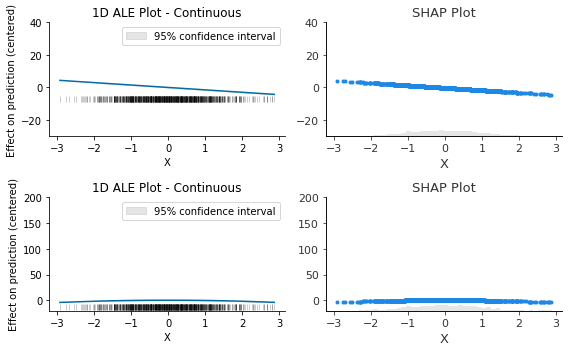

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5))
axes = axes.ravel()
ale_eff = ale(
    X=black_box_X_train, 
    model=black_box_model, 
    feature=[treatment_name], 
    grid_size=50, 
    include_CI=True, 
    C=0.95, 
    fig=fig, 
    ax=axes[0]
)

shap.plots.scatter(
    shap_values[:, treatment_name], 
    ax=axes[1], 
    title='SHAP Plot', 
    ylabel=f'SHAP value for {treatment_name}', 
    show=False
)


ale_eff = ale(
    X=black_box_X_train, 
    model=CorrectModel(), 
    feature=[treatment_name], 
    grid_size=50, 
    include_CI=True, 
    C=0.95, 
    fig=fig, 
    ax=axes[2]
)

shap.plots.scatter(
    shap_values2[:, treatment_name], 
    ax=axes[3], 
    title='SHAP Plot', 
    ylabel=f'SHAP value for {treatment_name}', 
    show=False
)

axes[0].set_ylim(-30, 40)
axes[1].set_ylim(-30, 40)
axes[2].set_ylim(-20, 200)
axes[3].set_ylim(-20, 200)

axes[1].set_ylabel('')
axes[3].set_ylabel('')

sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()

# Counterfactual effect curves show additional information beyond the average

Counterfactual curves are useful on their own in addition to the average. Consider a case such as the following, where when we average the effect curves for $X_1$, it looks like there is no effect, but in reality, there is a nonzero TDP for every individual in the dataset.

\begin{align}
X_1 &= U_{X_1}\\
X_2 &= U_{X_2}\\
Y &= X_1 * X_2 + U_Y
\end{align}

where $U_{X_1}, U_{Y} \sim \mathcal{N}(0, 0.1)$ and $U_{X_2} \sim \mathcal{N}(0, 2)$. Consider the TDP for a random forest fit on this DGP.

Plotting total effect: 100%|██████████| 1000/1000 [00:04<00:00, 225.14it/s]


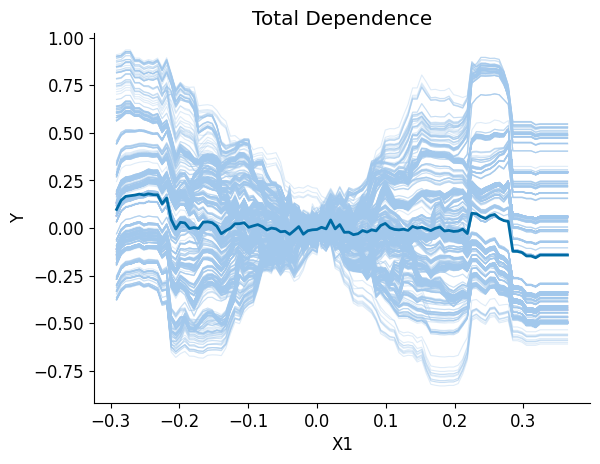

In [ ]:
# instantiate DGP
possible_X2_values_and_probabilities = ((-1, 1), (0.5, 0.5))
true_outcome_function = lambda x: x[:, 0] * x[:, 1]
node_function_dict = {
    'X1': (None, gcm.ScipyDistribution(stats.norm, loc=0, scale=0.1)),
    'X2': (None, gcm.ScipyDistribution(stats.norm, loc=0, scale=2)),
    'Y': (true_outcome_function, gcm.ScipyDistribution(stats.norm, loc=0, scale=0.1)),
}
causal_graph = nx.DiGraph([('X1', 'Y'), ('X2', 'Y')])
causal_model = build_ground_truth_causal_model(causal_graph=causal_graph, node_function_dict=node_function_dict)

# sample dataset
np.random.seed(789)
data_df = gcm.draw_samples(causal_model=causal_model, num_samples=1000)

black_box_X_train = data_df[['X1', 'X2']]
black_box_y_train = data_df['Y']
black_box_model = RandomForestRegressor()
explanatory_X_data = data_df[['X1', 'X2']]

# plot effects  
plotter = CausalDependencePlotter(
    black_box_X_train=black_box_X_train, 
    black_box_y_train=black_box_y_train,
    black_box_model=black_box_model,
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='Y',
    prefit_black_box=False,
    average_curve_color=colors[0],
    individual_curve_color=colors[7]
)
plotter.plot_total_effect(treatment_var='X1')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


# Linear model vs. random forest example

Next we combine the steps above for a new SCM: $P \sim \mathcal{U}[0,1.5]$; $F = 2P^3 + \mathcal{N}(0,0.2^2)$; and $S = F - P^2 + \mathcal{N}(0,0.2^2)$. For this example we'll compare the TDP and NDP for a linear model compared to a random forest.

Plotting total effect: 100%|██████████| 100/100 [00:01<00:00, 81.37it/s]


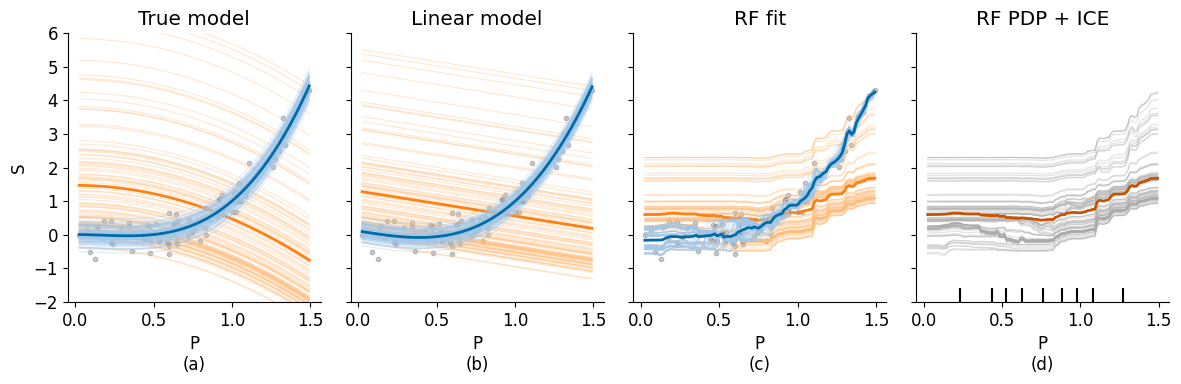

In [ ]:
np.random.seed(123)

true_outcome_function = lambda x: x[:, 0] - x[:, 1]**2

class CorrectModel(base.BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X_df):
        X = X_df[['F', 'P']].values
        return true_outcome_function(X)

node_function_dict = {
    # node: (prediction_function, noise_model)
    'P': (None, gcm.ScipyDistribution(stats.uniform, loc=0, scale=1.5)),
    'F': (lambda x: 2 * x**3, gcm.ScipyDistribution(stats.norm, loc=0, scale=0.2)),
    'S': (true_outcome_function, gcm.ScipyDistribution(stats.norm, loc=0, scale=0.2))
}
causal_graph = nx.DiGraph([('P', 'F'), ('P', 'S'), ('F', 'S')])
causal_model = build_ground_truth_causal_model(causal_graph=causal_graph, node_function_dict=node_function_dict)

data_df = gcm.draw_samples(causal_model=causal_model, num_samples=100)

black_box_X_train = data_df[['P', 'F']]
black_box_y_train = data_df['S']

explanatory_X_data = data_df[['P', 'F']]

black_box_rf = RandomForestRegressor(n_estimators=1000)
black_box_rf.fit(black_box_X_train, black_box_y_train)

plotter_linmod = CausalDependencePlotter(
    black_box_X_train=black_box_X_train, 
    black_box_y_train=black_box_y_train,
    black_box_model=LinearRegression(),
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='S',
    average_alpha_level=1.0,
    individual_alpha_level=0.35
)

plotter_rf = CausalDependencePlotter(
    black_box_model=black_box_rf,
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='S',
    prefit_black_box=True,
    average_alpha_level=plotter_linmod.average_alpha_level,
    individual_alpha_level=plotter_linmod.individual_alpha_level
)

plotter_truth = CausalDependencePlotter(
    black_box_X_train=black_box_X_train, 
    black_box_y_train=black_box_y_train,
    black_box_model=CorrectModel(),
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='S',
    average_alpha_level=plotter_linmod.average_alpha_level,
    individual_alpha_level=plotter_linmod.individual_alpha_level
)

treatment_name = 'P'
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4), sharey=True)
axes = axes.ravel()
PartialDependenceDisplay.from_estimator(
    estimator=black_box_rf,
    X=black_box_X_train, 
    features=[treatment_name],
    kind='both',
    percentiles=(0.0, 1.0),
    line_kw=dict(alpha=plotter_rf.average_alpha_level),
    pd_line_kw=dict(color=pale_red, linestyle='solid', linewidth=2.0),
    ice_lines_kw=dict(color=pale_gray, linewidth=0.8, alpha=plotter_rf.individual_alpha_level),
    ax=axes[3]
)
xlab = 'P'
ylab = 'S'
tdp_average_color = colors[0] # 'blue'  # '#177CB5'
tdp_individual_color = colors[7] # 'dodgerblue'  # '#56B4E9' # '#56B4E9'
nddp_average_color = colors[1] # 'pink'  # '#E69F00'
nddp_individual_color = colors[8] #'black' # '#E69F00'

tdp_linestyle = 'solid'
nddp_linestyle = 'solid'

pdp_ylim = plt.gca().get_ylim()
new_ylim = (pdp_ylim[0] - 1, pdp_ylim[1] + 1)
plt.gca().get_legend().remove()
plt.gca().set_ylim(new_ylim)
pdp_yticks = plt.gca().get_yticks()
plt.gca().set_xlabel(f'{xlab}\n(d)')
plt.gca().set_ylabel('')
plt.gca().set_yticks(pdp_yticks, labels=[])
axes[3].set_title('RF PDP + ICE')
plotter_truth.individual_curve_color = nddp_individual_color
plotter_truth.average_curve_color = nddp_average_color
plotter_truth.linestyle = nddp_linestyle
plotter_truth.plot_direct_effect(treatment_var=treatment_name, axis=axes[0])
plotter_truth.individual_curve_color = tdp_individual_color
plotter_truth.average_curve_color = tdp_average_color
plotter_truth.linestyle = tdp_linestyle
plotter_truth.plot_total_effect(treatment_var=treatment_name, axis=axes[0])
axes[0].set_title('True model')
axes[0].scatter(black_box_X_train[treatment_name], black_box_y_train, color='black', alpha=0.2, s=10)
plotter_linmod.individual_curve_color = nddp_individual_color
plotter_linmod.average_curve_color = nddp_average_color
plotter_linmod.linestyle = nddp_linestyle
plotter_linmod.plot_direct_effect(treatment_var=treatment_name, axis=axes[1])
plotter_linmod.individual_curve_color = tdp_individual_color
plotter_linmod.average_curve_color = tdp_average_color
plotter_linmod.linestyle = tdp_linestyle
plotter_linmod.plot_total_effect(treatment_var=treatment_name, axis=axes[1])
axes[1].scatter(black_box_X_train[treatment_name], black_box_y_train, color='black', alpha=0.2, s=10)
axes[1].set_title('Linear model')
plotter_rf.individual_curve_color = nddp_individual_color
plotter_rf.average_curve_color = nddp_average_color
plotter_rf.linestyle = nddp_linestyle
plotter_rf.plot_direct_effect(treatment_var=treatment_name, axis=axes[2])
plotter_rf.individual_curve_color = tdp_individual_color
plotter_rf.average_curve_color = tdp_average_color
plotter_rf.linestyle = tdp_linestyle
plotter_rf.plot_total_effect(treatment_var=treatment_name, axis=axes[2])
axes[2].set_title('RF fit')
axes[2].scatter(black_box_X_train[treatment_name], black_box_y_train, color='black', alpha=0.2, s=10)
for i in range(3):
    # some redundancy here
    axes[i].set_ylim(new_ylim)
    axes[i].set_xlabel(f"{xlab}\n({['a', 'b', 'c'][i]})")
    axes[i].set_ylabel(ylab)
    axes[i].set_yticks(pdp_yticks)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

# Comparison to ALE and SHAP plots — random forest model revisited

CDPs also capture information not shown by ALE and SHAP plots. Revisiting the same random forest example with PDPs from above ($P \sim \mathcal{U}[0,1.5]$; $F = 2P^3 + \mathcal{N}(0,0.2^2)$; and $S = F - P^2 + \mathcal{N}(0,0.2^2)$), consider the following.

Plotting total effect: 100%|██████████| 100/100 [00:00<00:00, 230.34it/s]
PyALE._ALE_generic:INFO: Continuous feature detected.
ExactExplainer explainer: 101it [00:14,  2.62it/s]                         


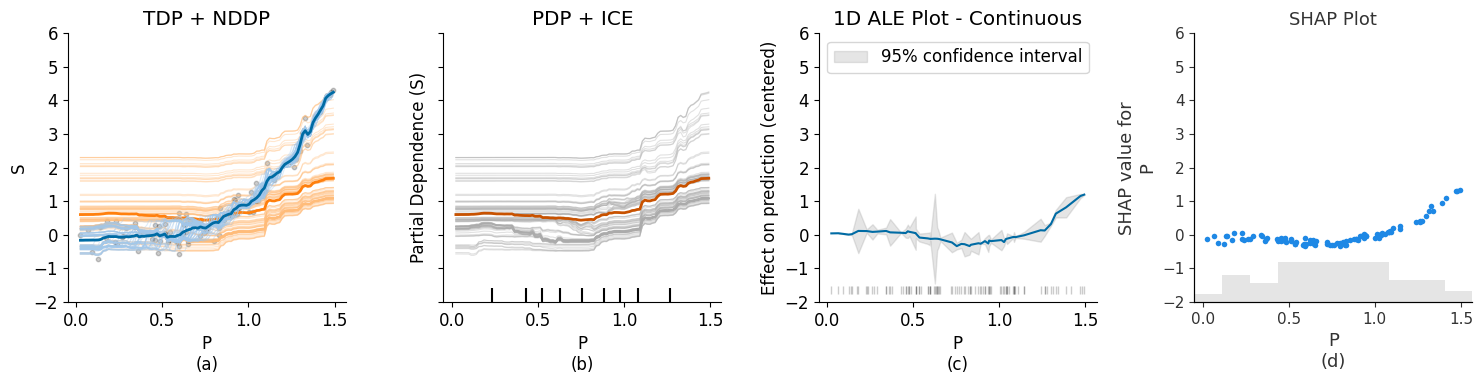

In [ ]:
np.random.seed(123)

true_outcome_function = lambda x: x[:, 0] - x[:, 1]**2

class CorrectModel(base.BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X_df):
        X = X_df[['F', 'P']].values
        return true_outcome_function(X)

node_function_dict = {
    # node: (prediction_function, noise_model)
    'P': (None, gcm.ScipyDistribution(stats.uniform, loc=0, scale=1.5)),
    'F': (lambda x: 2 * x**3, gcm.ScipyDistribution(stats.norm, loc=0, scale=0.2)),
    'S': (true_outcome_function, gcm.ScipyDistribution(stats.norm, loc=0, scale=0.2))
}
causal_graph = nx.DiGraph([('P', 'F'), ('P', 'S'), ('F', 'S')])
causal_model = build_ground_truth_causal_model(causal_graph=causal_graph, node_function_dict=node_function_dict)

data_df = gcm.draw_samples(causal_model=causal_model, num_samples=100)

black_box_X_train = data_df[['P', 'F']]
black_box_y_train = data_df['S']

explanatory_X_data = data_df[['P', 'F']]

black_box_rf = RandomForestRegressor(n_estimators=1000)
black_box_rf.fit(black_box_X_train, black_box_y_train)

plotter_rf = CausalDependencePlotter(
    black_box_model=black_box_rf,
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='S',
    prefit_black_box=True,
    average_alpha_level=1.0,
    individual_alpha_level=0.35
)

treatment_name = 'P'
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 4), sharey=False)
axes = axes.ravel()
PartialDependenceDisplay.from_estimator(
    estimator=black_box_rf,
    X=black_box_X_train, 
    features=[treatment_name],
    kind='both',
    percentiles=(0.0, 1.0),
    line_kw=dict(alpha=plotter_rf.average_alpha_level),
    pd_line_kw=dict(color=pale_red, linestyle='solid', linewidth=2.0),
    ice_lines_kw=dict(color=pale_gray, linewidth=0.8, alpha=plotter_rf.individual_alpha_level),
    ax=axes[1]
)
xlab = 'P'
ylab = 'S'
tdp_average_color = colors[0] # 'blue'  # '#177CB5'
tdp_individual_color = colors[7] # 'dodgerblue'  # '#56B4E9' # '#56B4E9'
nddp_average_color = colors[1] # 'pink'  # '#E69F00'
nddp_individual_color = colors[8] #'black' # '#E69F00'

tdp_linestyle = 'solid'
nddp_linestyle = 'solid'

pdp_ylim = plt.gca().get_ylim()
new_ylim = (pdp_ylim[0] - 1, pdp_ylim[1] + 1)
plt.gca().get_legend().remove()
plt.gca().set_ylim(new_ylim)
pdp_yticks = plt.gca().get_yticks()
plt.gca().set_xlabel(f'{xlab}\n(b)')
plt.gca().set_ylabel('Partial Dependence (S)')
plt.gca().set_yticks(pdp_yticks, labels=[])
axes[1].set_title('PDP + ICE')
sns.despine(top=True, right=True, left=False, bottom=False, ax=axes[1])

plotter_rf.individual_curve_color = nddp_individual_color
plotter_rf.average_curve_color = nddp_average_color
plotter_rf.linestyle = nddp_linestyle
plotter_rf.plot_direct_effect(treatment_var=treatment_name, axis=axes[0])
plotter_rf.individual_curve_color = tdp_individual_color
plotter_rf.average_curve_color = tdp_average_color
plotter_rf.linestyle = tdp_linestyle
plotter_rf.plot_total_effect(treatment_var=treatment_name, axis=axes[0])
axes[0].set_title('TDP + NDDP')
axes[0].scatter(black_box_X_train[treatment_name], black_box_y_train, color='black', alpha=0.2, s=10)

# make ALE plot
ale_eff = ale(
    X=black_box_X_train, 
    model=black_box_rf, 
    feature=[treatment_name], 
    grid_size=50, 
    include_CI=True, 
    C=0.95, 
    fig=fig, 
    ax=axes[2]
)

explainer = shap.Explainer(black_box_rf.predict, explanatory_X_data[black_box_rf.feature_names_in_])
shap_values = explainer(explanatory_X_data[black_box_rf.feature_names_in_])
shap.plots.scatter(
    shap_values[:, treatment_name], 
    ax=axes[3], 
    title='SHAP Plot', 
    ylabel=f'SHAP value for {treatment_name}', 
    ymin=new_ylim[0], 
    ymax=new_ylim[1],
    show=False
)

for i in range(4):
    # some redundancy here
    axes[i].set_ylim(new_ylim)
    axes[i].set_xlabel(f"{xlab}\n({['a', 'b', 'c', 'd'][i]})")
    # axes[i].set_ylabel(ylab)
    axes[i].set_yticks(pdp_yticks)
    sns.despine(top=True, right=True, left=False, bottom=False, ax=axes[i])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

# Visualizing uncertainty about causal models

We can simultaneously visualize a set of models we may be uncertain about. Consider a set of two candidate models -- one with an edge between $P$ and $F$ and one without.
- Model 1: $P \sim \mathcal{U}[0,1.5]$; $F = 2P^3 + \mathcal{N}(0,0.2^2)$; and $S = F - P^2 + \mathcal{N}(0,0.2^2)$
- Model 2: $P \sim \mathcal{U}[0,1.5]$; $F \sim \mathcal{N}(1,0.2^2)$; and $S = F - P^2 + \mathcal{N}(0,0.2^2)$

Model 1:


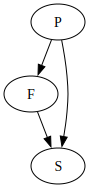

Model 2:


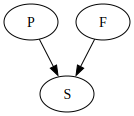

Sampling NIE counterfactuals: 100%|██████████| 100/100 [00:19<00:00,  5.26it/s]


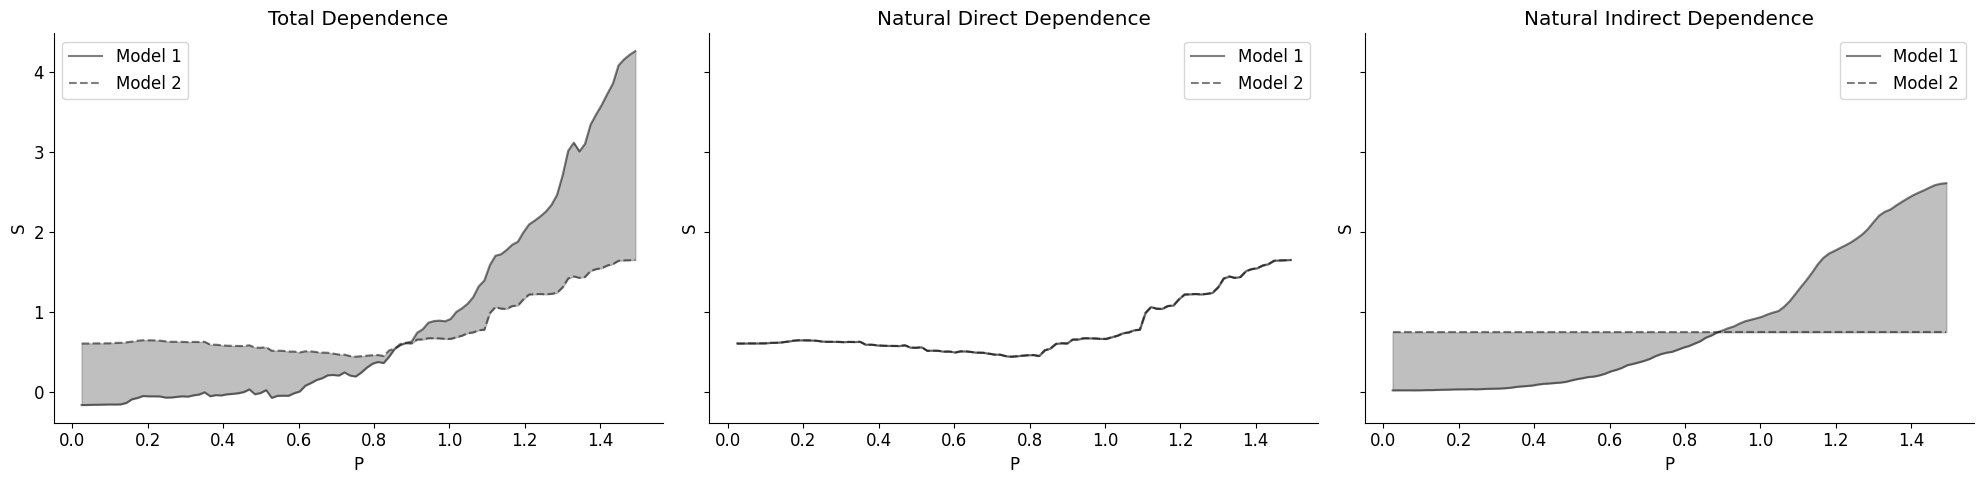

In [ ]:
np.random.seed(123)

true_outcome_function = lambda x: x[:, 0] - x[:, 1]**2

class CorrectModel(base.BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X_df):
        X = X_df[['F', 'P']].values
        return true_outcome_function(X)

node_function_dict_1 = {
    # node: (prediction_function, noise_model)
    'P': (None, gcm.ScipyDistribution(stats.uniform, loc=0, scale=1.5)),
    'F': (lambda x: 2 * x**3, gcm.ScipyDistribution(stats.norm, loc=0, scale=0.2)),
    'S': (true_outcome_function, gcm.ScipyDistribution(stats.norm, loc=0, scale=0.2))
}
causal_graph_1 = nx.DiGraph([('P', 'F'), ('P', 'S'), ('F', 'S')])
causal_model_1 = build_ground_truth_causal_model(causal_graph=causal_graph_1, node_function_dict=node_function_dict_1)

node_function_dict_2 = {
    # node: (prediction_function, noise_model)
    'P': (None, gcm.ScipyDistribution(stats.uniform, loc=0, scale=1.5)),
    'F': (None, gcm.ScipyDistribution(stats.norm, loc=1, scale=0.2)),
    'S': (true_outcome_function, gcm.ScipyDistribution(stats.norm, loc=0, scale=0.2))
}
causal_graph_2 = nx.DiGraph([('P', 'S'), ('F', 'S')])
causal_model_2 = build_ground_truth_causal_model(causal_graph=causal_graph_2, node_function_dict=node_function_dict_2)

causal_model_list = [causal_model_1, causal_model_2]

data_df = gcm.draw_samples(causal_model=causal_model_1, num_samples=100)

black_box_X_train = data_df[['P', 'F']]
black_box_y_train = data_df['S']

explanatory_X_data = data_df[['P', 'F']]

uncertain_plotter = UncertainCausalDependencePlotter(
    black_box_X_train=black_box_X_train, 
    black_box_y_train=black_box_y_train,
    black_box_model=RandomForestRegressor(n_estimators=1000),
    causal_model_list=causal_model_list,
    explanatory_X_data=explanatory_X_data,
    outcome_name='S'
)

print('Model 1:')
display(get_dot_graph(graph=causal_graph_1))
print('Model 2:')
display(get_dot_graph(graph=causal_graph_2))

treatment_name = 'P'
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharey=True)
axes = axes.ravel()
uncertain_plotter.plot_total_effect(treatment_var=treatment_name, axis=axes[0])
uncertain_plotter.plot_direct_effect(treatment_var=treatment_name, axis=axes[1])
uncertain_plotter.plot_indirect_effect(treatment_var=treatment_name, axis=axes[2])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

# Using the PC Algorithm with the Breast Cancer Wisconsin (Original) Dataset

The PC algorithm returns an undirected edge between `Uniformity of Cell Shape` and `Uniformity of Cell Size`. We can (1) choose a direction for this edge to generate CDPs, or (2) visualize our uncertainty across the different options for edges between these two variables. We demonstrate both options below.

,Clump thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Normal Nucleoli,Class
0,5.0,1.0,1.0,1.0,1.0,2.0
1,5.0,4.0,4.0,5.0,2.0,2.0
2,3.0,1.0,1.0,1.0,1.0,2.0
3,6.0,8.0,8.0,1.0,7.0,2.0
4,4.0,1.0,1.0,3.0,1.0,2.0


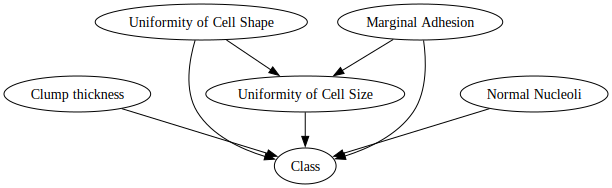

Plotting indirect effect: 100%|██████████| 699/699 [00:29<00:00, 24.05it/s]


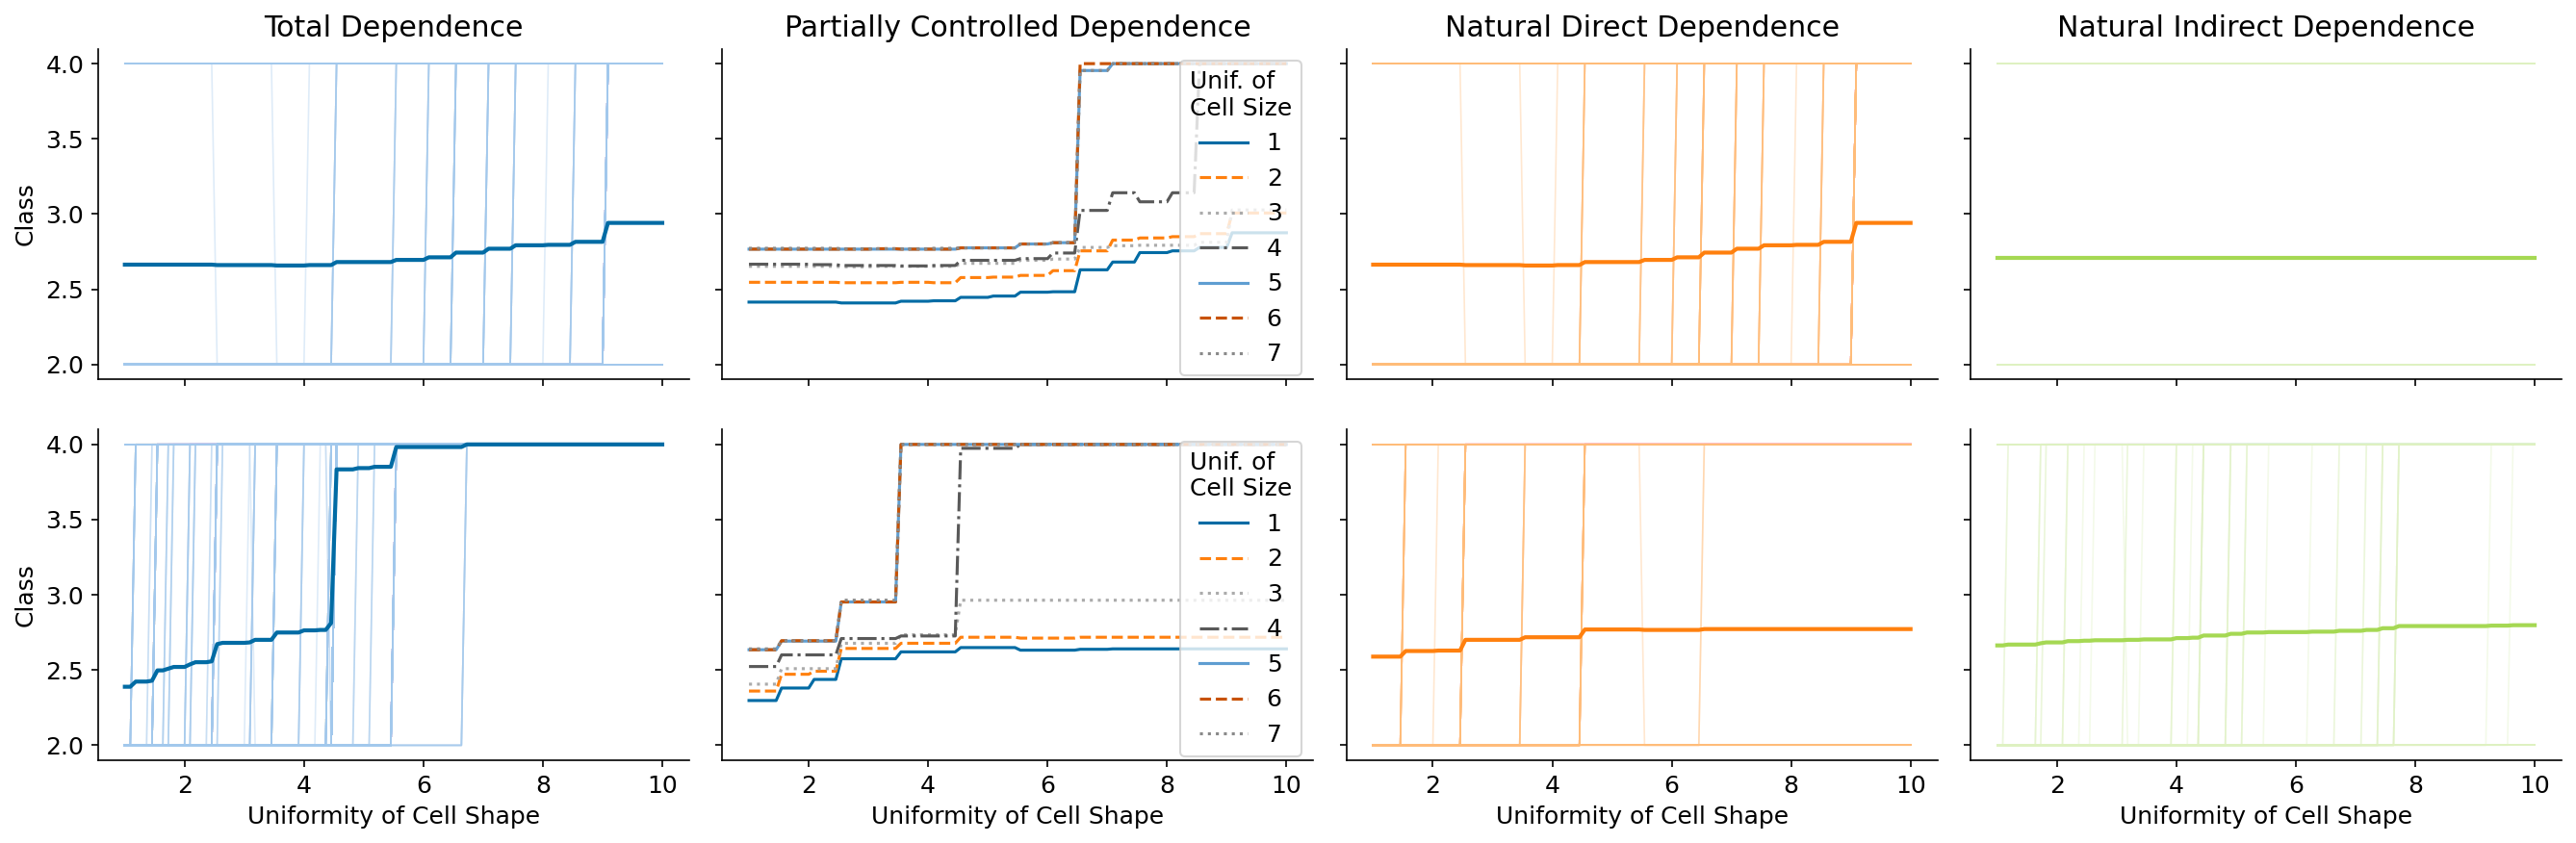

In [ ]:
# load data
df_breast_cancer = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data', 
                            header=None, na_values='?')
df_breast_cancer = df_breast_cancer.rename(columns={0: 'ID', 1: 'Clump thickness', 2: 'Uniformity of Cell Size', 
                              3: 'Uniformity of Cell Shape', 4:'Marginal Adhesion', 
                              5:'Single Epithelial Cell Size', 6: 'Bare Nuclei', 
                              7: 'Bland Chromatin', 8:'Normal Nucleoli', 9:'Mitoses', 10: 'Class'})
df_breast_cancer.dropna()
df_breast_cancer = df_breast_cancer.drop(['ID'], axis=1)
df_breast_cancer = df_breast_cancer.apply(pd.to_numeric, downcast="float")
df_breast_cancer.to_csv('breast_cancer.csv')

# select variables of interest
df_breast_cancer = df_breast_cancer.drop(['Bland Chromatin', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Mitoses'], axis=1)
display(df_breast_cancer.head())

# DAG found from PC algorithm 
bc_graph = nx.DiGraph([('Clump thickness', 'Class'), ('Uniformity of Cell Size', 'Class'), 
                       ('Uniformity of Cell Shape', 'Class'),('Marginal Adhesion', 'Class'), 
                       ('Normal Nucleoli', 'Class'), ('Uniformity of Cell Shape', 'Uniformity of Cell Size'), 
                       ('Marginal Adhesion', 'Uniformity of Cell Size') ])

display(get_dot_graph(bc_graph))

# fit on data using auto-assigned additive noise models
causal_model_bc = gcm.InvertibleStructuralCausalModel(bc_graph)
gcm.auto.assign_causal_mechanisms(causal_model=causal_model_bc, based_on=df_breast_cancer, quality=gcm.auto.AssignmentQuality.GOOD)
gcm.fit(causal_model_bc, df_breast_cancer)

# define treatment and outcome
treatment_name = 'Clump thickness'
outcome_name = 'Class'
covariates_list = list(sorted(df_breast_cancer.columns.tolist()))
covariates_list.remove(outcome_name)

black_box_X_train = df_breast_cancer[covariates_list]
black_box_y_train = df_breast_cancer[outcome_name]

explanatory_X_data = df_breast_cancer[covariates_list]

plotter_bc = CausalDependencePlotter(
    black_box_X_train=black_box_X_train, 
    black_box_y_train=black_box_y_train,
    black_box_model=RandomForestClassifier(max_depth=5, random_state=0),
    fit_causal_model=causal_model_bc,
    explanatory_X_data=explanatory_X_data,
    outcome_name=outcome_name,
    prefit_black_box=False,
    average_curve_color=colors[0],
    individual_curve_color=colors[7]
)

fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(18, 6), dpi=150)
axes = axes.ravel()
treatment_one = 'Clump thickness'
treatment_two = 'Uniformity of Cell Shape'
plotter_bc.plot_total_effect(treatment_var=treatment_one, axis=axes[0])
plotter_bc.plot_controlled_effect(
    treatment_var=treatment_one, 
    control_vars=('Uniformity of Cell Size',), 
    control_tuples=[(val,) for val in range(1, 8)], 
    combine_plots=True, 
    axis=axes[1]
)
plotter_bc.average_curve_color = colors[1]
plotter_bc.individual_curve_color = colors[8]
plotter_bc.plot_direct_effect(treatment_var=treatment_one, axis=axes[2])
plotter_bc.average_curve_color = colors[5]
plotter_bc.individual_curve_color = colors[2]
plotter_bc.plot_indirect_effect(treatment_var=treatment_one, axis=axes[3])
plotter_bc.average_curve_color = colors[0]
plotter_bc.individual_curve_color = colors[7]
plotter_bc.plot_total_effect(treatment_var=treatment_two, axis=axes[4])
axes[4].set_title('')
plotter_bc.plot_controlled_effect(
    treatment_var=treatment_two, 
    control_vars=('Uniformity of Cell Size',), 
    control_tuples=[(val,) for val in range(1, 8)], 
    combine_plots=True, 
    axis=axes[5]
)
axes[5].set_title('')
plotter_bc.average_curve_color = colors[1]
plotter_bc.individual_curve_color = colors[8]
plotter_bc.plot_direct_effect(treatment_var=treatment_two, axis=axes[6])
axes[6].set_title('')
plotter_bc.average_curve_color = colors[5]
plotter_bc.individual_curve_color = colors[2]
plotter_bc.plot_indirect_effect(treatment_var=treatment_two, axis=axes[7])
axes[7].set_title('')
axes[1].legend(title='Unif. of\nCell Size')
axes[5].legend(title='Unif. of\nCell Size')
# plt.yticks(ticks=[2.0, 4.0], labels=['Benign', 'Malignant'])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

Model 1:


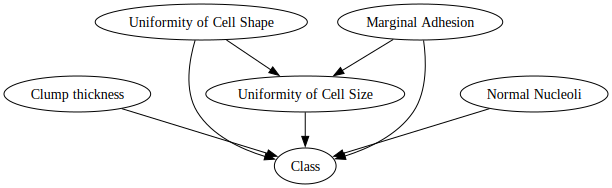

Fitting causal mechanism of node Normal Nucleoli: 100%|██████████| 6/6 [00:00<00:00, 524.62it/s]

Model 2:


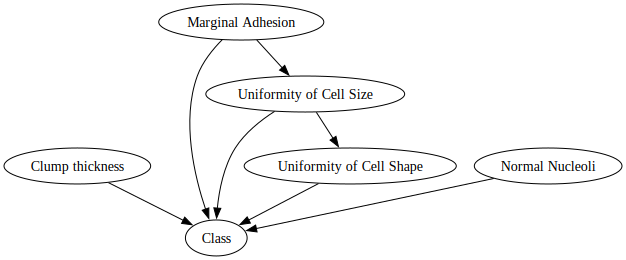

Fitting causal mechanism of node Normal Nucleoli: 100%|██████████| 6/6 [00:00<00:00, 500.24it/s]

Model 3:


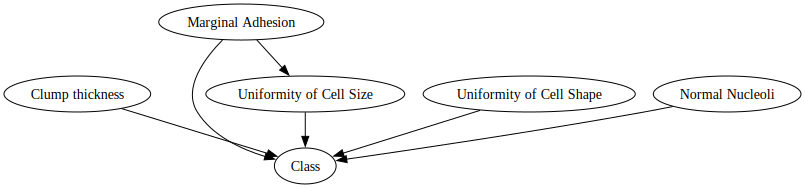

Sampling NIE counterfactuals: 100%|██████████| 100/100 [00:04<00:00, 24.93it/s]


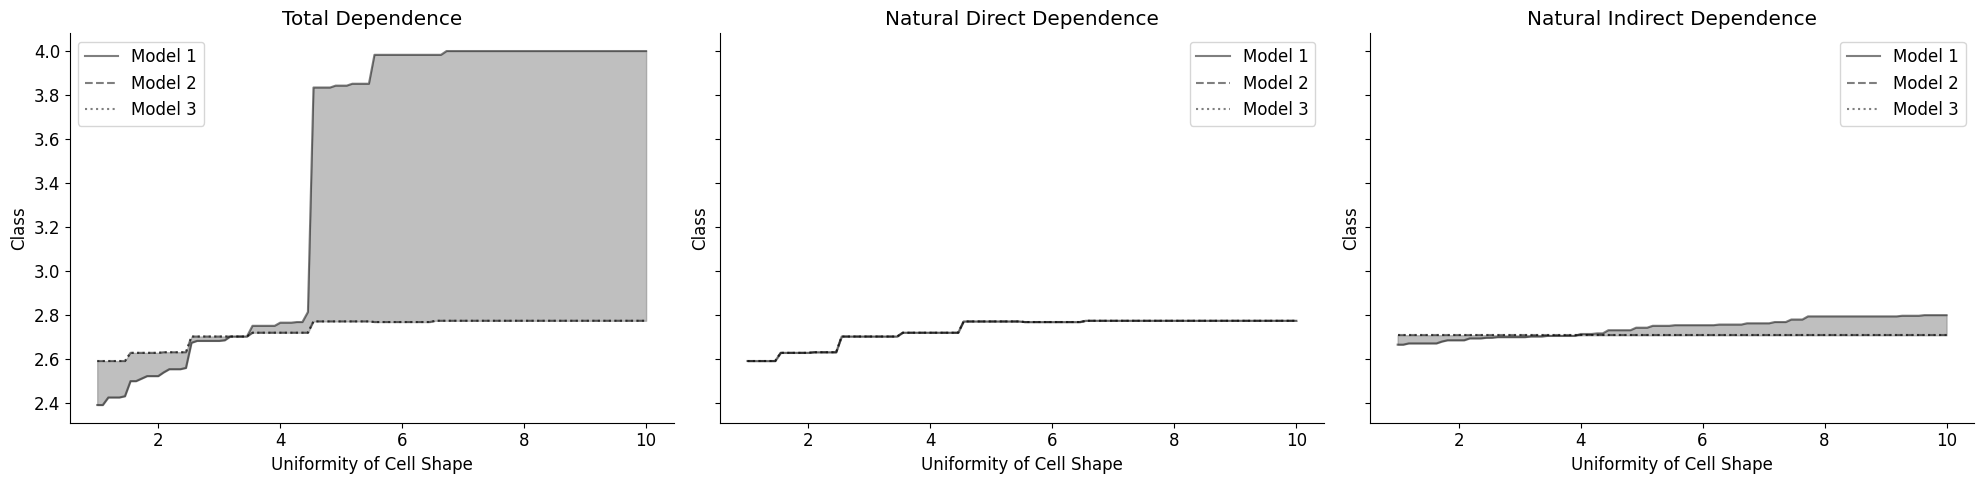

In [ ]:
# fit three different graphs
bc_graph_1 = nx.DiGraph([('Clump thickness', 'Class'), ('Uniformity of Cell Size', 'Class'), 
                       ('Uniformity of Cell Shape', 'Class'),('Marginal Adhesion', 'Class'), 
                       ('Normal Nucleoli', 'Class'), ('Uniformity of Cell Shape', 'Uniformity of Cell Size'), 
                       ('Marginal Adhesion', 'Uniformity of Cell Size') ])
print('Model 1:')
display(get_dot_graph(bc_graph_1))
bc_causal_model_1 = gcm.InvertibleStructuralCausalModel(bc_graph_1)
gcm.auto.assign_causal_mechanisms(
    causal_model=bc_causal_model_1, 
    based_on=df_breast_cancer, 
    quality=gcm.auto.AssignmentQuality.GOOD
)
gcm.fit(bc_causal_model_1, df_breast_cancer)

bc_graph_2 = nx.DiGraph([('Clump thickness', 'Class'), ('Uniformity of Cell Size', 'Class'), 
                       ('Uniformity of Cell Shape', 'Class'),('Marginal Adhesion', 'Class'), 
                       ('Normal Nucleoli', 'Class'), ('Uniformity of Cell Size', 'Uniformity of Cell Shape'), 
                       ('Marginal Adhesion', 'Uniformity of Cell Size') ])
print('Model 2:')
display(get_dot_graph(bc_graph_2))
bc_causal_model_2 = gcm.InvertibleStructuralCausalModel(bc_graph_2)
gcm.auto.assign_causal_mechanisms(
    causal_model=bc_causal_model_2, 
    based_on=df_breast_cancer, 
    quality=gcm.auto.AssignmentQuality.GOOD
)
gcm.fit(bc_causal_model_2, df_breast_cancer)

bc_graph_3 = nx.DiGraph([('Clump thickness', 'Class'), ('Uniformity of Cell Size', 'Class'), 
                       ('Uniformity of Cell Shape', 'Class'),('Marginal Adhesion', 'Class'), 
                       ('Normal Nucleoli', 'Class'), ('Marginal Adhesion', 'Uniformity of Cell Size') ])
print('Model 3:')
display(get_dot_graph(bc_graph_3))
bc_causal_model_3 = gcm.InvertibleStructuralCausalModel(bc_graph_3)
gcm.auto.assign_causal_mechanisms(
    causal_model=bc_causal_model_3, 
    based_on=df_breast_cancer, 
    quality=gcm.auto.AssignmentQuality.GOOD
)
gcm.fit(bc_causal_model_3, df_breast_cancer)

# define treatment and outcome
treatment_name = 'Uniformity of Cell Shape'
outcome_name = 'Class'
covariates_list = list(sorted(df_breast_cancer.columns.tolist()))
covariates_list.remove(outcome_name)

black_box_X_train = df_breast_cancer[covariates_list]
black_box_y_train = df_breast_cancer[outcome_name]

explanatory_X_data = df_breast_cancer[covariates_list]

black_box_model = RandomForestClassifier(max_depth=5, random_state=0)
black_box_model.fit(black_box_X_train, black_box_y_train)

uncertain_plotter_bc = UncertainCausalDependencePlotter(
    black_box_model=black_box_model,
    causal_model_list=[bc_causal_model_1, bc_causal_model_2, bc_causal_model_3],
    explanatory_X_data=explanatory_X_data,
    outcome_name=outcome_name,
    prefit_black_box=True
)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5), sharey=True)
axes = axes.ravel()
uncertain_plotter_bc.plot_total_effect(treatment_var=treatment_name, axis=axes[0])
uncertain_plotter_bc.plot_direct_effect(treatment_var=treatment_name, axis=axes[1])
uncertain_plotter_bc.plot_indirect_effect(treatment_var=treatment_name, axis=axes[2])
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

# Using an established DAG for the Sachs Dataset

(7466, 11)


,praf,pmek,plcg,PIP2,PIP3,p44/42,pakts473,PKA,PKC,P38,pjnk
0,26.4,13.2,8.82,18.30,58.80,6.61,17.0,414.0,17.00,44.9,40.0
1,35.9,16.5,12.30,16.80,8.13,18.60,32.5,352.0,3.37,16.5,61.5
2,59.4,44.1,14.60,10.20,13.00,14.90,32.5,403.0,11.40,31.9,19.5
3,73.0,82.8,23.10,13.50,1.29,5.83,11.8,528.0,13.70,28.6,23.1
4,33.7,19.8,5.19,9.73,24.80,21.10,46.1,305.0,4.66,25.7,81.3


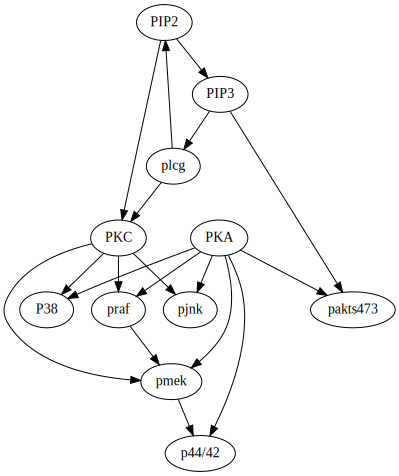

In [ ]:
data_sachs, graph_sachs = load_dataset("sachs")
data_sachs.dropna(inplace=True)
print(data_sachs.shape)
display(data_sachs.head())
display(get_dot_graph(graph_sachs))

Removing edge: ('PIP2', 'PIP3')
Adding edge: ('PIP3', 'PIP2')


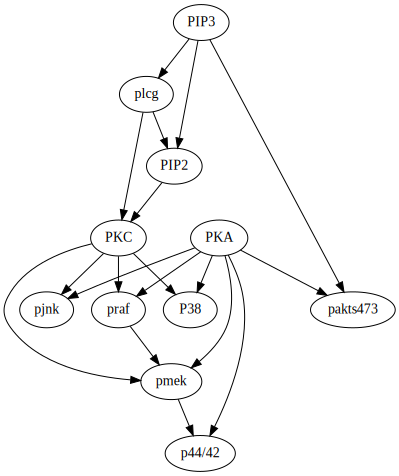

Fitting causal mechanism of node pakts473: 100%|██████████| 11/11 [00:05<00:00,  2.17it/s]
Exact explainer: 7467it [09:00, 13.54it/s]                          


Sampling TE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting total effect:   0%|          | 0/7466 [00:00<?, ?it/s]

Sampling NDE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting direct effect:   0%|          | 0/7466 [00:00<?, ?it/s]

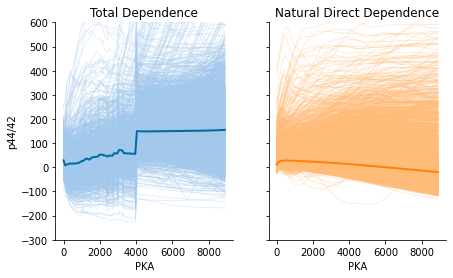

In [ ]:
# instantiate causal model on true graph, removing the first edge that makes a cycle
# reverse the plcg - PIP2 edge following https://arxiv.org/pdf/1805.03108.pdf
causal_graph = graph_sachs.copy()
# cycle_inducing_edges = nx.find_cycle(causal_graph)
edge_to_reverse = ('PIP2', 'PIP3')
print(f'Removing edge: {edge_to_reverse}')
causal_graph.remove_edge(*edge_to_reverse)
reversed_edge = tuple(reversed(edge_to_reverse))
print(f'Adding edge: {reversed_edge}')
causal_graph.add_edge(*reversed_edge)
display(get_dot_graph(causal_graph))
causal_model = gcm.InvertibleStructuralCausalModel(causal_graph)

# fit on data using auto-assigned additive noise models
gcm.auto.assign_causal_mechanisms(causal_model=causal_model, based_on=data_sachs, quality=gcm.auto.AssignmentQuality.BETTER)
gcm.fit(causal_model, data_sachs)

# define treatment and outcome
treatment_name = 'PKA'
outcome_name = 'p44/42'
covariates_list = data_sachs.columns.tolist()
covariates_list.remove(outcome_name)

black_box_X_train = data_sachs[covariates_list]
black_box_y_train = data_sachs[outcome_name]

explanatory_X_data = data_sachs[covariates_list]

black_box = MLPRegressor(random_state=123)
black_box.fit(black_box_X_train, black_box_y_train)
explainer = shap.Explainer(black_box.predict, explanatory_X_data[black_box.feature_names_in_])
shap_values = explainer(explanatory_X_data[black_box.feature_names_in_])

plotter_sachs = CausalDependencePlotter(
    black_box_X_train=black_box_X_train, 
    black_box_y_train=black_box_y_train,
    black_box_model=black_box,
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name=outcome_name,
    prefit_black_box=False,
    average_curve_color=colors[0],
    individual_curve_color=colors[7]
)

plotter_sachs.average_alpha_level = 1
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 4), sharey=True)
axes = axes.ravel()
plotter_sachs.plot_total_effect(treatment_var=treatment_name, axis=axes[0])
plotter_sachs.average_curve_color = colors[1]
plotter_sachs.individual_curve_color = colors[8]
plotter_sachs.plot_direct_effect(treatment_var=treatment_name, axis=axes[1])
plt.ylim(-300, 600)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Sampling NDE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting direct effect:   0%|          | 0/7466 [00:00<?, ?it/s]

Sampling TE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting total effect:   0%|          | 0/7466 [00:00<?, ?it/s]

PyALE._ALE_generic:INFO: Continuous feature detected.


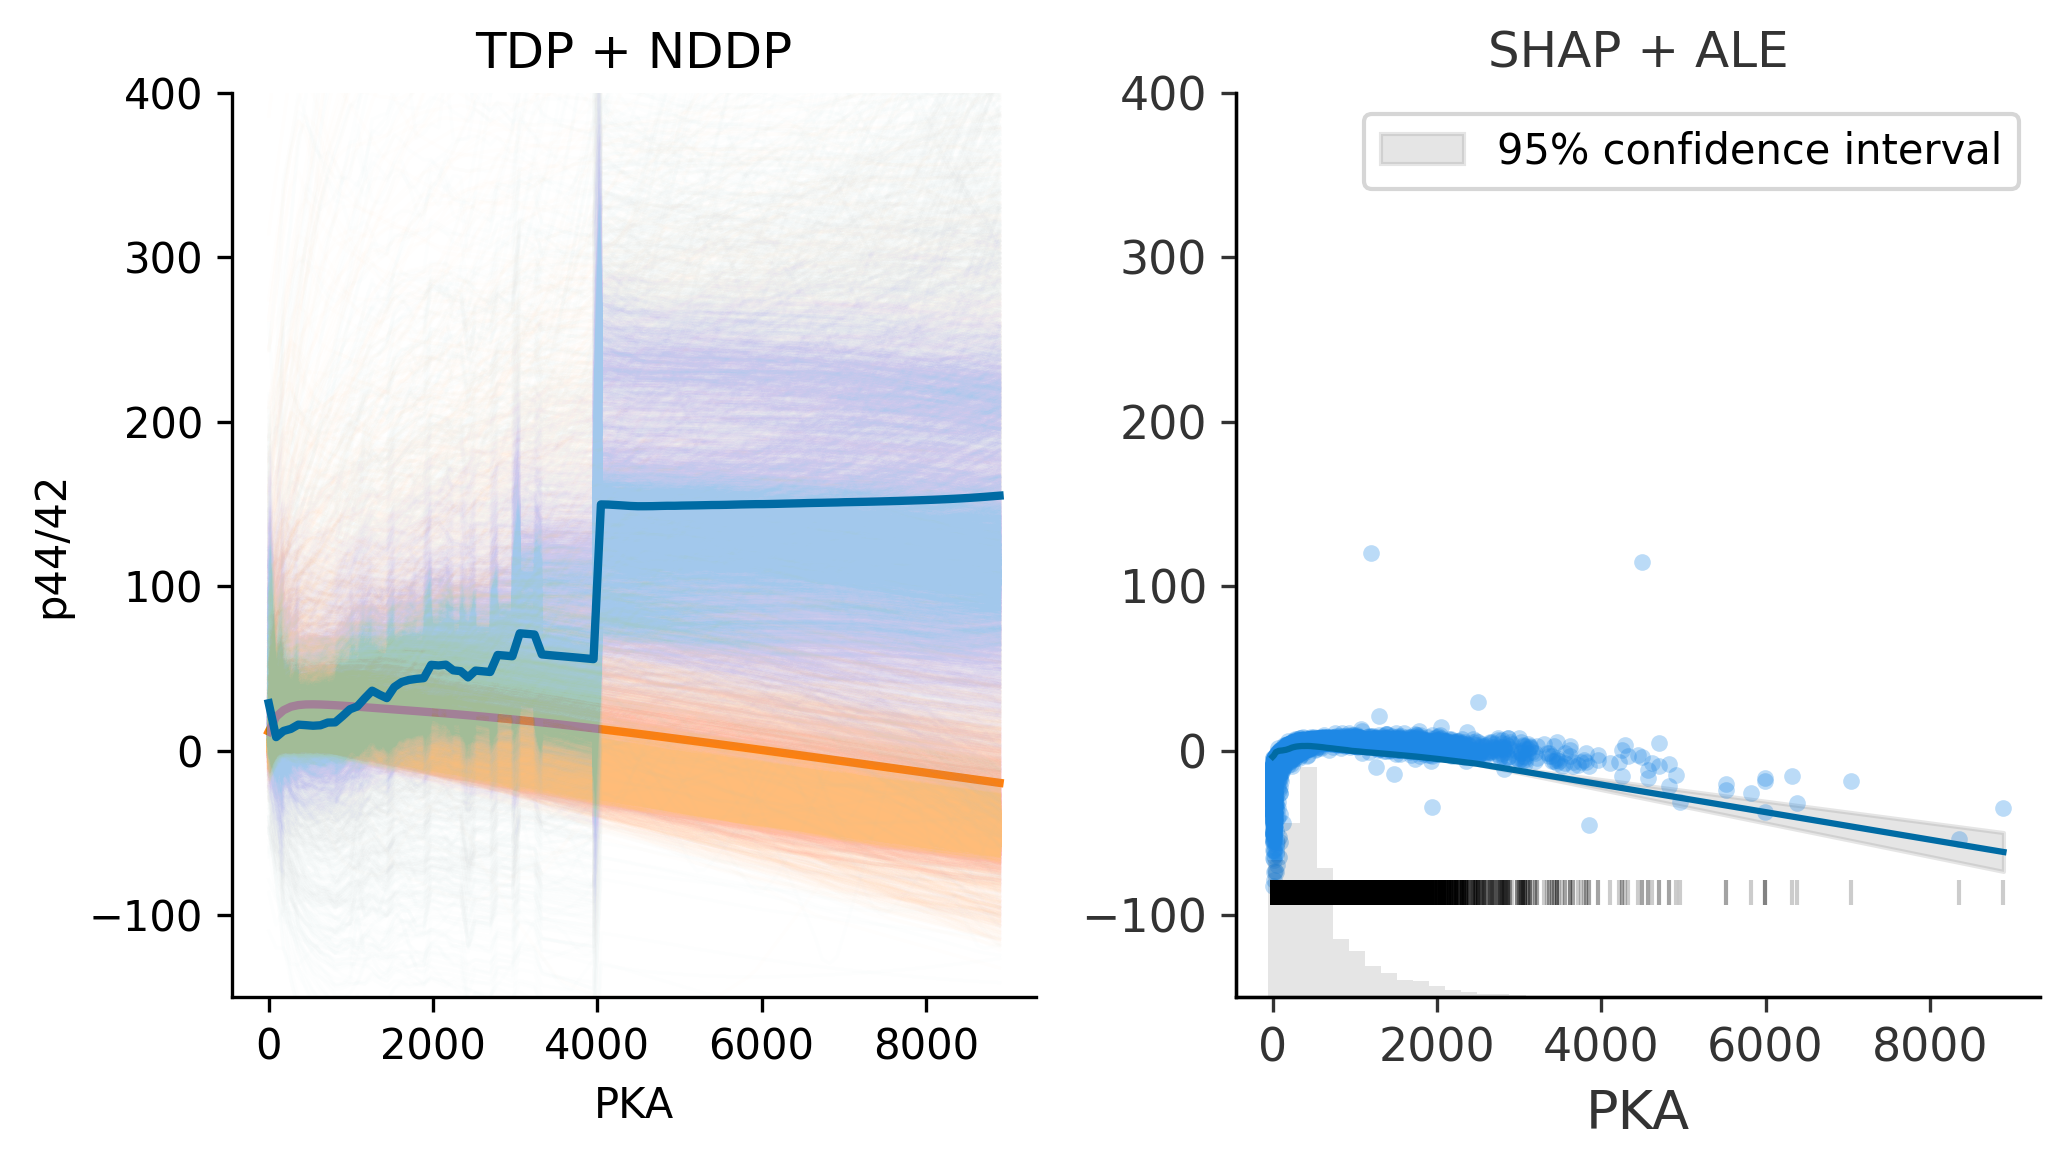

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


plotter_sachs.average_alpha_level = 1
plotter_sachs.individual_alpha_level=0.01

plotter_sachs.individual_curve_color = nddp_individual_color
plotter_sachs.average_curve_color = nddp_average_color
plotter_sachs.linestyle = nddp_linestyle
plotter_sachs.plot_direct_effect(treatment_var=treatment_name, axis=axes[0])
plotter_sachs.individual_curve_color = tdp_individual_color
plotter_sachs.average_curve_color = tdp_average_color
plotter_sachs.linestyle = tdp_linestyle
plotter_sachs.plot_total_effect(treatment_var=treatment_name, axis=axes[0])
axes[0].scatter(black_box_X_train[treatment_name], black_box_y_train, color='black', alpha=0.001, s=10)

ale_eff = ale(
    X=black_box_X_train, 
    model=black_box, 
    feature=[treatment_name], 
    grid_size=50, 
    include_CI=True, 
    C=0.95, 
    fig=fig, 
    ax=axes[1]
)
sns.despine(top=True, right=True, left=False, bottom=False)

shap.plots.scatter(
    shap_values[:, treatment_name], 
    cmap="plasma",
    #color='red',
    alpha=0.3,
    ax=axes[1], 
    title='SHAP Plot', 
    ylabel=f'SHAP value for {treatment_name}', 
    ymin=-200, 
    ymax=600,
    show=False,
)

axes[0].set_ylim(-150,400)
axes[1].set_ylim(-150,400)

axes[0].set_title('TDP + NDDP')
axes[1].set_title('SHAP + ALE')
axes[0].set_xlabel('PKA')
axes[1].set_xlabel('PKA')
axes[1].set_ylabel('')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.savefig('myfigure_200.png', dpi=400)
plt.show()

# Plotting residuals and distribution shifts

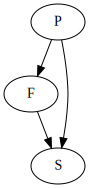

Sampling TE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting total effect:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling TE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting total effect:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling TE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting total effect:   0%|          | 0/100 [00:00<?, ?it/s]

Sampling TE counterfactuals:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting total effect:   0%|          | 0/100 [00:00<?, ?it/s]

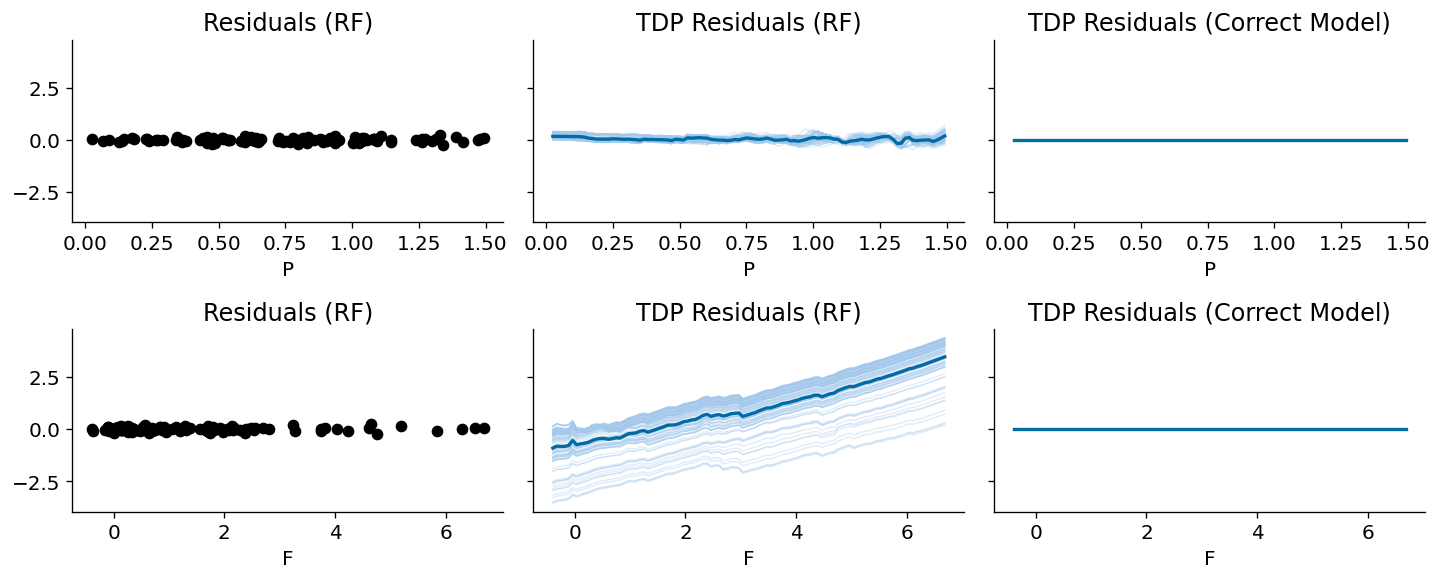

In [ ]:
np.random.seed(123)

true_outcome_function = lambda x: x[:, 0] - x[:, 1]**2

class CorrectModel(base.BaseEstimator):
    def fit(self, X, y):
        pass
    def predict(self, X_df):
        X = X_df[['F', 'P']].values
        return true_outcome_function(X)

node_function_dict = {
    'P': (None, gcm.ScipyDistribution(stats.uniform, loc=0, scale=1.5)),
    'F': (lambda x: 2 * x**3, gcm.ScipyDistribution(stats.norm, loc=0, scale=0.2)),
    'S': (true_outcome_function, gcm.ScipyDistribution(stats.norm, loc=0, scale=0.2))
}

class ResidualModel(base.BaseEstimator):
    def fit(self, X, y):
        self.model = RandomForestRegressor(n_estimators=1000).fit(X=X, y=y)
        self.feature_names_in_ = list(X.columns)
        self._estimator_type = 'regressor'
    def predict(self, X_df):
        X = X_df[sorted(self.feature_names_in_)].values
        residuals = np.squeeze(true_outcome_function(X)) - np.squeeze(self.model.predict(X=X_df[self.feature_names_in_]))
        return residuals


class CorrectResidualModel(base.BaseEstimator):
    def fit(self, X, y):
        self.model = CorrectModel()
        self.feature_names_in_ = list(X.columns)
        self._estimator_type = 'regressor'
    def predict(self, X_df):
        X = X_df[sorted(self.feature_names_in_)].values
        residuals = np.squeeze(true_outcome_function(X)) - np.squeeze(self.model.predict(X_df=X_df[self.feature_names_in_]))
        return residuals


causal_graph = nx.DiGraph([('P', 'F'), ('P', 'S'), ('F', 'S')])
causal_model = build_ground_truth_causal_model(causal_graph=causal_graph, node_function_dict=node_function_dict)
display(get_dot_graph(causal_graph))

data_df = gcm.draw_samples(causal_model=causal_model, num_samples=100)

black_box_feature_names = ['P', 'F']
black_box_X_train = data_df[black_box_feature_names]
black_box_y_train = data_df['S']
black_box_model = ResidualModel()
correct_model = CorrectResidualModel()
black_box_model.fit(X=black_box_X_train, y=black_box_y_train)
correct_model.fit(X=black_box_X_train, y=black_box_y_train)

y_pred = black_box_model.model.predict(black_box_X_train[black_box_model.feature_names_in_])
df_plot = black_box_X_train.copy(deep=True)
df_plot['Y_hat'] = y_pred
df_plot['Y_res'] = black_box_y_train - y_pred

explanatory_X_data = black_box_X_train.copy(deep=True)

# plot effects  
plotter = CausalDependencePlotter(
    black_box_model=black_box_model,
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='S',
    prefit_black_box=True,
    average_curve_color=colors[0],
    individual_curve_color=colors[7]
)
correct_plotter = CausalDependencePlotter(
    black_box_model=correct_model,
    fit_causal_model=causal_model,
    explanatory_X_data=explanatory_X_data,
    outcome_name='S',
    prefit_black_box=True,
    average_curve_color=colors[0],
    individual_curve_color=colors[7]
)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), dpi=120, sharey=True)
axes = axes.ravel()
plotter.plot_total_effect(treatment_var='P', axis=axes[1])
axes[1].set_title('TDP Residuals (RF)')

correct_plotter.plot_total_effect(treatment_var='P', axis=axes[2])
axes[2].set_title('TDP Residuals (Correct Model)')

axes[0].scatter(df_plot['P'], df_plot['Y_res'], color='black')
axes[0].set_title('Residuals (RF)')
axes[0].set_xlabel('P')

plotter.plot_total_effect(treatment_var='F', axis=axes[4])
axes[4].set_title('TDP Residuals (RF)')

correct_plotter.plot_total_effect(treatment_var='F', axis=axes[5])
axes[5].set_title('TDP Residuals (Correct Model)')

axes[3].scatter(df_plot['F'], df_plot['Y_res'], color='black')
axes[3].set_title('Residuals (RF)')
axes[3].set_xlabel('F')

sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()